Data source:http://yann.lecun.com/exdb/mnist/; tutorial:https://www.bilibili.com/video/BV14J411X7Bb?p=9

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
# https://pytorch.org/get-started/locally/  <- Download Package from here

In [2]:
import torch
# https://pytorch.org/docs/stable/torchvision/datasets.html
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    #用来正常显示负号

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
# 载入数据时使用的处理器个数
num_workers=0
#每一批的数据个数
batch_size=20
#验证集所占比例
valid_size=0.2
#将数据转换为Pytorch的张量Tensor类型
transform=transforms.ToTensor()

# 选择testing/training dataset
# root: 数据集文件根目录 这里是data/MNIST/raw
# train: 是否载入训练集。download: 如果目录中找不到数据集，是否自动下载。
# transform：将载入的数据按上面transform定义的方式进行转换

train_data = datasets.MNIST(root='data',train=True,download=True,transform=transform)
test_data = datasets.MNIST(root='data',train=False,download=True,transform=transform)

In [5]:
# 将训练集每张图像对应的索引随机打乱，将索引分为训练集索引和验证集索引
num_train = len(train_data)
indices=list(range(num_train))
np.random.shuffle(indices)
split=int(np.floor(valid_size * num_train))
train_idx,valid_idx = indices[split:],indices[:split]  # 48000,12000


In [6]:
# 划分为新的traning和testing
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [100]:
# 创建训练集、验证集、测试机、的数据Loader，python中的生成器，每一次调用返回一个batch的数据
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                          sampler=train_sampler,num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,
                                          num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                          sampler=valid_sampler,num_workers=num_workers)

#### Visualize Data

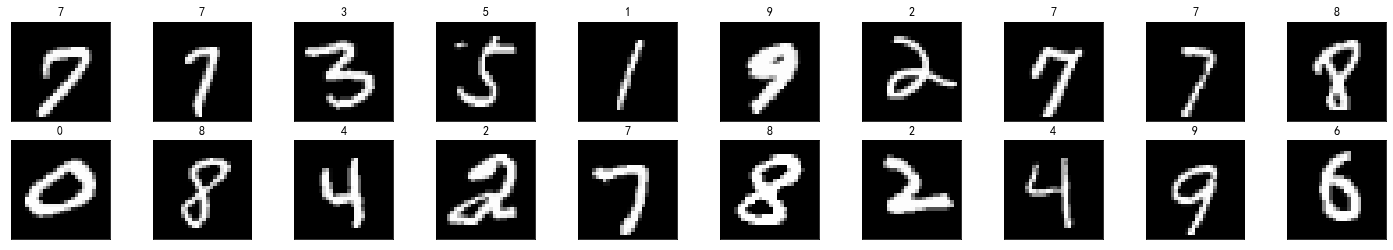

In [9]:
# 重复运行，展示不同的图片

# 构造迭代器，获得训练集中的一批次数据
dataiter = iter(train_loader)
images,labels=dataiter.next()

# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

# 可视化图片和标签
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[idx]),cmap='gray')
    # .item()获取张量的数值
    ax.set_title(str(labels[idx].item()))

In [11]:
np.squeeze(images[1]).shape #Remove single-dimensional entries from the shape of an array

(28, 28)

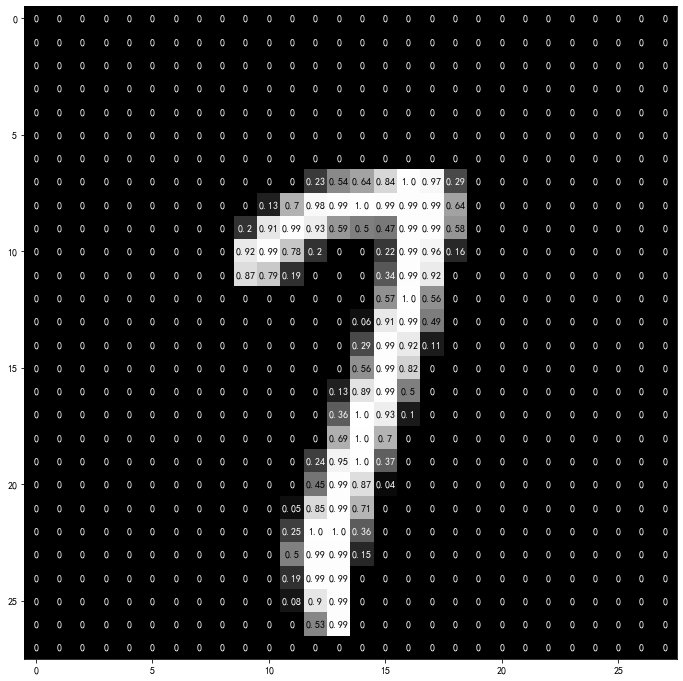

In [13]:
# visualize image

img=np.squeeze(images[1])
fig=plt.figure(figsize=(12,12))
ax=fig.add_subplot()
ax.imshow(img,cmap='gray')
width,height = img.shape
thresh=img.max()/2.5

#iterate each pixel
for x in range(width):
    for y in range(height):
        val=round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val),xy=(y,x),
                   horizontalalignment='center',
                   verticalalignment='center',
                   color='white' if img[x][y]<thresh else 'black')

#### NN 神经网络

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        #定义第一个隐含层和第二个隐含层的神经元个数
        hidden_1=512
        hidden_2=512
        
        #输入层到隐含层，输入维度为784，输出维度为hidden_1
        self.fc1 = nn.Linear(28*28,hidden_1)
        #第一层隐含层到第二层隐含层，输入维度为hidden_1,输出维度为hidden_2
        self.fc2 = nn.Linear(hidden_1,hidden_2)
        #第二层隐含层到输出层，输入维度为hidden_2,输出维度为10
        self.fc3 = nn.Linear(hidden_2,10)
        #定义Dropout率为0.2，防止过拟合
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,x):
        #将原始图像拉平成784维的长向量
        x = x.view(-1,28*28)
        #经过第一层隐含层，激活函数为relu
        x = F.relu(self.fc1(x))
        #Dropout层
        x = self.dropout(x)
        #经过第二程隐含层，激活函数为relu
        x = F.relu(self.fc2(x))
        #Dropout层
        x = self.dropout(x)
        #输出层
        x = self.fc3(x)
        return x
    
# 实例化模型，打印模型信息
model = NN()
print(model)
        

NN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### 定义损失函数和梯度下降优化器


###### 使用交叉熵作为分类问题的损失函数，从Pytorch文档可知，Pytorch中的交叉熵其实包含了softmax和对数损失的计算
###### Pytorch-损失函数：http://pytorch.org/docs/stable/nn.html#loss-functions
###### Pytorch-梯度下降优化器：http://pytorch.org/docs/stable/optim.html

In [18]:
# 损失函数为交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 定义优化器（随机梯度下降SGD优化器，学习率0.01）
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

### Train NN

In [20]:
# 1. 清除所有梯度 optimizer.zero_grad()
# 2. 正向预测，求出模型对训练集数据的预测分类 output=model(data)
# 3. 计算损失函数 loss = criterion(output,target)
# 4. 反向传播，将损失函数对每一个权重求导，求得每个权重对应的梯度 loss.backward()
# 5. 优化器执行单步的优化（权重更新）optimizer.step()
# 6. 计算每一轮的平均训练误差和验证误差

In [21]:
len(train_loader.dataset)

60000

In [24]:
# 训练轮次数，每一轮都完整遍历数据集中的所有图像
n_epochs=50

# 初始话验证集的最小误差为正无穷
valid_loss_min=np.Inf

# 将训练过程中的训练损失和验证损失存储在列表中
train_loss_list=[]
val_loss_list=[]

# 每一轮训练:
for epoch in range(n_epochs):
    # 初始化训练损失和验证损失
    train_loss=0.0
    valid_loss=0.0
    
    ################
    #---Training---#      
    ################
    model.train() #将模型调整为训练模式
    
    # 从train_loader中获取一批次的数据和标签
    for data,target in train_loader:
        #将所有梯度归零
        optimizer.zero_grad()
        #正向推断，求得预测结果
        output=model(data)
        #比较预测结果和标签，计算损失函数
        loss=criterion(output,target)
        #反向传播，将损失函数对每一个权重求导，求得每个权重对应的梯度
        loss.backward()
        #优化器执行单步的优化（权重更新）
        optimizer.step()
        #将本批次所有样本的损失函数值求和，作为训练损失
        train_loss+=loss.item()*data.size(0)
        
    ################
    #----Testing---#      
    ################
    model.eval() #将模型调整为验证模式，关闭Dropout和BN层
    # 从验证集valid_loader中获得一个批次的数据及标签
    for data,target in valid_loader:
        #正向推断，求得预测结果
        output=model(data)
        #计算损失函数
        loss=criterion(output,target)
        #将本批次所有样本的损失函数值求和，作为验证损失
        valid_loss+=loss.item()*data.size(0)
        
    #结束了本轮的训练和验证，打印训练和验证指标
    #计算平均训练损失和平均验证损失，存储在列表中
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    val_loss_list.append(valid_loss)
        
    print('Round{} \t Training Loss: {:.6f} \t Valid_loss: {:.6f}'.format(epoch+1,train_loss,valid_loss))
    
    #如果验证误差相比上一轮有降低，及时保存模型在本地的model.pt文件中
    if valid_loss <= valid_loss_min:
        print('Valid_loss decrease ({:.6f} --> {:.6f}). 保存模型'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(),'model.pt')
        valid_loss_min = valid_loss

Round1 	 Training Loss: 0.283348 	 Valid_loss: 0.057851
Valid_loss decrease (inf --> 0.057851). 保存模型
Round2 	 Training Loss: 0.225482 	 Valid_loss: 0.048188
Valid_loss decrease (0.057851 --> 0.048188). 保存模型
Round3 	 Training Loss: 0.184964 	 Valid_loss: 0.040089
Valid_loss decrease (0.048188 --> 0.040089). 保存模型
Round4 	 Training Loss: 0.159195 	 Valid_loss: 0.035569
Valid_loss decrease (0.040089 --> 0.035569). 保存模型
Round5 	 Training Loss: 0.137953 	 Valid_loss: 0.031506
Valid_loss decrease (0.035569 --> 0.031506). 保存模型
Round6 	 Training Loss: 0.120315 	 Valid_loss: 0.028383
Valid_loss decrease (0.031506 --> 0.028383). 保存模型
Round7 	 Training Loss: 0.108806 	 Valid_loss: 0.026566
Valid_loss decrease (0.028383 --> 0.026566). 保存模型
Round8 	 Training Loss: 0.097556 	 Valid_loss: 0.024858
Valid_loss decrease (0.026566 --> 0.024858). 保存模型
Round9 	 Training Loss: 0.088906 	 Valid_loss: 0.023322
Valid_loss decrease (0.024858 --> 0.023322). 保存模型
Round10 	 Training Loss: 0.081648 	 Valid_loss: 0.0

#### 可视化训练误差和验证误差 Visualize Train_loss & Valid_loss

<function matplotlib.pyplot.show(close=None, block=None)>

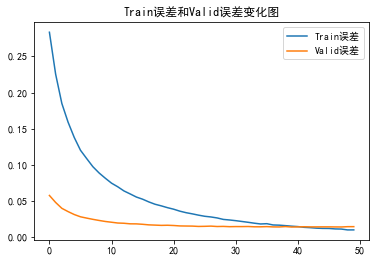

In [25]:
plt.plot(train_loss_list,label='Train误差')
plt.plot(val_loss_list,label='Valid误差')
plt.legend()
plt.title('Train误差和Valid误差变化图')
plt.show
# 都在降低，没有发生过拟合

<function matplotlib.pyplot.show(close=None, block=None)>

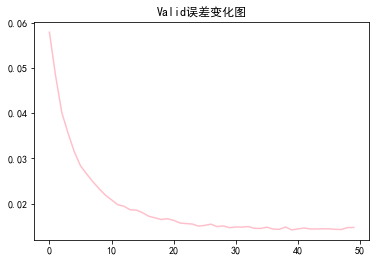

In [26]:
plt.plot(val_loss_list,label='Valid误差',c='pink')
plt.title('Valid误差变化图')
plt.show
# 前十轮下降较快，往后趋于平缓

In [27]:
# Load lowest valid_loss model
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

### 在测试集上评估模型 Evaluate model on testing data

In [66]:
#初始化测试误差
test_loss=0.0
class_correct=list(0. for i in range(10))
class_total=list(0. for i in range(10))

In [67]:
#存储每种数字正确识别的个数
class_correct

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [68]:
#存储每种数字总的样本数
class_total

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [69]:
dataiter=iter(train_loader)
data,target=dataiter.next()

In [70]:
print(data.shape,target.shape)

torch.Size([20, 1, 28, 28]) torch.Size([20])


In [71]:
target

tensor([4, 2, 8, 3, 0, 2, 8, 3, 0, 7, 9, 0, 7, 9, 7, 9, 4, 1, 4, 7])

In [72]:
# 将模型调整到验证阶段，关闭Droupout和BN层
model.eval()

NN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [73]:
# 正向预测，预测每张图片的分类
output=model(data)

In [74]:
output.shape

torch.Size([20, 10])

In [75]:
output[0]

tensor([ 1.4356, -4.3430,  1.7169, -6.2664, 13.1677, -5.0285,  3.9310, -0.6057,
        -6.0755,  2.6162], grad_fn=<SelectBackward>)

In [76]:
# 计算交叉熵损失函数
loss = criterion(output,target)
loss

tensor(0.0009, grad_fn=<NllLossBackward>)

In [77]:
# 将本批次所有样本的损失函数值求和，作为测试损失
test_loss += loss.item() * data.size(0)
test_loss

0.01734717166982591

In [78]:
# 将输出最大值对应的神经元作为预测分类
_,pred = torch.max(output,1)
pred

tensor([4, 2, 8, 3, 0, 2, 8, 3, 0, 7, 9, 0, 7, 9, 7, 9, 4, 1, 4, 7])

In [79]:
target
# 这组data中完全正确

tensor([4, 2, 8, 3, 0, 2, 8, 3, 0, 7, 9, 0, 7, 9, 7, 9, 4, 1, 4, 7])

In [80]:
# 比较预测的分类和真实标签，如果相等则取1
correct= np.squeeze(pred.eq(target.data.view_as(pred)))
correct

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

In [81]:
# 遍历本batch中的所有数字，将correct加到美国数字对应的正确识别个数上
for i in range(batch_size):
    label=target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label]+=1
    print(class_correct[label])

1.0
1.0
1.0
1.0
1.0
2.0
2.0
2.0
2.0
1.0
1.0
3.0
2.0
2.0
3.0
3.0
2.0
1.0
3.0
4.0


In [82]:
# 每一种数字有多少被分类正确了
class_correct

[3.0, 1.0, 2.0, 2.0, 3.0, 0.0, 0.0, 4.0, 2.0, 3.0]

In [86]:
# 每一种数字总共有多少样本
class_total

[3.0, 1.0, 2.0, 2.0, 3.0, 0.0, 0.0, 4.0, 2.0, 3.0]

In [88]:
# Evaluate on the whole testing dataset
model.eval() # 将模型调整到验证阶段，关闭Droupout和BN层

NN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [102]:
# 从测试集中取出一个Batch的数据和标签
for data,target in test_loader:
    # 正向预测，预测每张图片的分类
    output = model(data)
    # 计算交叉熵损失函数
    loss = criterion(output,target)
    # 将本批次所有样本的损失函数值求和，作为测试损失
    test_loss+=loss.item()*data.size(0)
    # 将输出最大值对应的神经元作为预测分类
    _,pred = torch.max(output,1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label=target.data[i]
        class_correct[label]+=correct[i].item()
        class_total[label]+=1
        
# 计算平均测试误差
test_loss = test_loss/len(test_loader.dataset)
print("Testing_Loss: {:.6f}".format(test_loss))

Testing_Loss: 0.061108


In [103]:
class_correct

[974.0, 1126.0, 1012.0, 1001.0, 956.0, 863.0, 941.0, 1003.0, 952.0, 994.0]

In [104]:
class_total

[983.0, 1136.0, 1034.0, 1012.0, 985.0, 892.0, 958.0, 1032.0, 976.0, 1012.0]

In [107]:
for i in range(10):
    print('数字{}在测试机上的识别正确率为{:.5f}% ({:.0f}/{:.0f})'.format(i,class_correct[i]*100/class_total[i],class_correct[i],class_total[i]))
    
# 其中1最容易预测对，5最容易预测错

数字0在测试机上的识别正确率为99.08444% (974/983)
数字1在测试机上的识别正确率为99.11972% (1126/1136)
数字2在测试机上的识别正确率为97.87234% (1012/1034)
数字3在测试机上的识别正确率为98.91304% (1001/1012)
数字4在测试机上的识别正确率为97.05584% (956/985)
数字5在测试机上的识别正确率为96.74888% (863/892)
数字6在测试机上的识别正确率为98.22547% (941/958)
数字7在测试机上的识别正确率为97.18992% (1003/1032)
数字8在测试机上的识别正确率为97.54098% (952/976)
数字9在测试机上的识别正确率为98.22134% (994/1012)


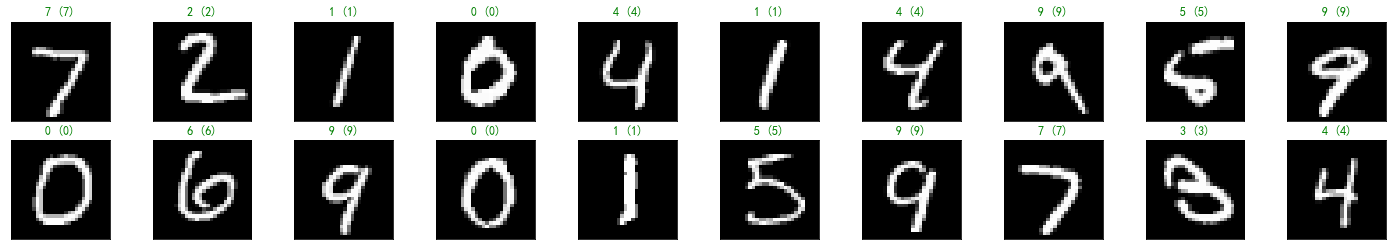

In [115]:
# 可视化测试集中一些图片和预测结果
# （）里为真实标签，识别正确显示绿色，错误显示红色

# 获得测试集一个batch的数据和标签
dataiter = iter(test_loader)
images,labels=dataiter.next()

# 正向推断
output = model(images)
# 取概率最高的分类作为分类结果
_, preds = torch.max(output,1)
# 将数据从Torch张量转换为numpy的array
images = images.numpy()

# 可视化本batch中图片、预测种类、真实种类
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[idx]),cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()),str(labels[idx].item())),
                color=("green" if preds[idx]==labels[idx] else "red"))